# BottomTrendFollow Researches

Obtain results with naive transaction that no adjusting lot, leverage, and trading strategy.

まずはナイーブな取引、つまりロットもレバレッジも取引戦略も調整していない取引の結果を集計、計算する

In [1]:
%matplotlib inline
import research_kit as rk

rk.pd.set_option("display.max_columns", 250)
rk.pd.set_option("display.max_rows", 250)
import warnings
warnings.filterwarnings('ignore')


bot = rk.BottomTrendFollow(db_client=rk.mysql_client, exchange_client=rk.bitmex_exchange_client, is_backtest=True)

downloading BTC/USD data on bitmex
downloading 2019-12-30 00:17:30 ~ 2019-12-30 00:44:16.692523 data
100.0% completed


In [2]:
def show_bottom_trend_follow_params(bot):
    rk.pprint(bot.combined_params)
    
show_bottom_trend_follow_params(bot)

{'bot_name': 'bottom_trend_follow',
 'bottom_trend_tick': 12,
 'close_position_on_do_nothing': True,
 'inverse_trading': False,
 'middle_trend_tick': 6,
 'timeframe': 60,
 'top_trend_tick': 3}


In [3]:
def generate_transaction_log(bot, close_position_on_do_nothing=True, inverse_trading=False):
    backtest_start_time = rk.datetime(2019,9,30,11,49)
    backtest_end_time = rk.datetime(2019,12,29,11,49)
    
    ohlcv_df_1min = rk.dataset_manager.get_ohlcv(start_time=backtest_start_time, end_time=backtest_end_time)
    print("dataset size:" + str(len(ohlcv_df_1min)))
    
    timeframe_params = [60,30,10,1]
    bottom_trend_tick_params = [5,10,15,20,25,30,35,40,45,50]
    middle_trend_tick_params = [3,5,7,9,12,15,18,21,24,27,30]
    top_trend_tick_params = [1,2,3,4,5,6,7,8]
    
    calc_start_time = rk.datetime.now()
    
    for timeframe in timeframe_params:
        print("timeframe=>" + str(timeframe))
        for bottom_trend_tick in bottom_trend_tick_params:
            for middle_trend_tick in middle_trend_tick_params:           
                for top_trend_tick in top_trend_tick_params:
                    if bottom_trend_tick <= middle_trend_tick or middle_trend_tick <= top_trend_tick:
                        continue
                        
                    default_params = {
                        "bot_name": bot.bot_name,
                        "close_position_on_do_nothing": close_position_on_do_nothing,
                        "inverse_trading": inverse_trading,
                        "timeframe": int(timeframe)
                    }
                    
                    specific_params = {
                        "bottom_trend_tick": int(bottom_trend_tick),
                        "middle_trend_tick": int(middle_trend_tick),
                        "top_trend_tick": int(top_trend_tick)
                    }
                    
                    bot.reset_backtest_result_with_params(default_params, specific_params)
                    before_run = rk.datetime.now()
                    bot.run(ohlcv_df=ohlcv_df_1min[::timeframe], backtest_start_time=backtest_start_time,
                           backtest_end_time=backtest_end_time)
                    print("bottom_trend_tick=>" + str(bottom_trend_tick) +\
                          " midle_trend_tick=>" + str(middle_trend_tick) +\
                          " top_trend_tick=>" + str(top_trend_tick) + " time:" + str(rk.datetime.now() - before_run))
        bot.bulk_insert()
    print("total processing time:" + str(rk.datetime.now() - calc_start_time))

#generate_transaction_log(bot)
# it takes 4hours to calculate all wuth insert after getting transaction log before commit "optimize metrics calc"
#generate_transaction_log(bot, inverse_trading=False)
#generate_transaction_log(bot, inverse_trading=True)


In [4]:
def get_joined_params_and_summary(bot):
    backtest_management = bot.backtest_management_table()
    backtest_summary = rk.BacktestSummary()
    
    query_management = "SELECT * FROM " + bot.backtest_management_table_name + ";"
    query_summary = "SELECT * FROM backtest_summary;"
    
    backtest_management_df = rk.mysql_client.exec_sql(query_management)
    backtest_summary_df = rk.mysql_client.exec_sql(query_summary)
    
    merged_backtest_results = rk.pd.merge(backtest_management_df, backtest_summary_df, left_on="backtest_summary_id", right_on="id")
    return merged_backtest_results
    
merged_results = get_joined_params_and_summary(bot)
merged_results.style.set_table_styles([dict(selector="th",props=[('max-width', '50px')])])

normal_results = merged_results.query("inverse_trading == False")
inversed_results = merged_results.query("inverse_trading == True")

In [5]:
def profit_factor_analysis(df, figure_title):
    columns_picked_up = df.sort_values("profit_factor", ascending=False).loc[:,[
        "timeframe",
        "bottom_trend_tick",
        "middle_trend_tick",
        "top_trend_tick",
        "profit_factor"
    ]]
    
    timeframe_params = [60,30,10,1]
    
    fig_profit_factor_histogram = rk.plt.figure()
    fig_profit_factor_histogram.suptitle(figure_title, fontsize=16, y=1.01)
    #fig_profit_factor_histogram.subplots_adjust(wspace=0.4, hspace=0.6)
    profit_factor_histogram_all = fig_profit_factor_histogram.add_subplot(len(timeframe_params)+1,1,1)
    profit_factor_histogram_all.hist(df.profit_factor, bins=48)
    profit_factor_histogram_all.set_title("profit factor distribution for all rows")
    profit_factor_histogram_all.set_xlabel("profit factor")
    profit_factor_histogram_all.set_ylabel("freq")
    
    profit_factor_histogram_all.set_xlim(0.5,1.7)
    
    for i, timeframe in enumerate(timeframe_params):
        profit_factor_histogram = fig_profit_factor_histogram.add_subplot(len(timeframe_params) + 1,1, 2 + i)
        profit_factor_histogram.hist(columns_picked_up.query("timeframe==" + str(timeframe)).profit_factor, bins=48)
        profit_factor_histogram.set_title("profit factor distribution for timeframe=" + str(timeframe))
        profit_factor_histogram.set_xlabel("profit factor")
        profit_factor_histogram.set_ylabel("freq")
        
        profit_factor_histogram.set_xlim(0.5,1.7)
        
    fig_profit_factor_histogram.tight_layout()
    
rk.plt.rcParams['figure.figsize'] = (10.0, 20.0)

    

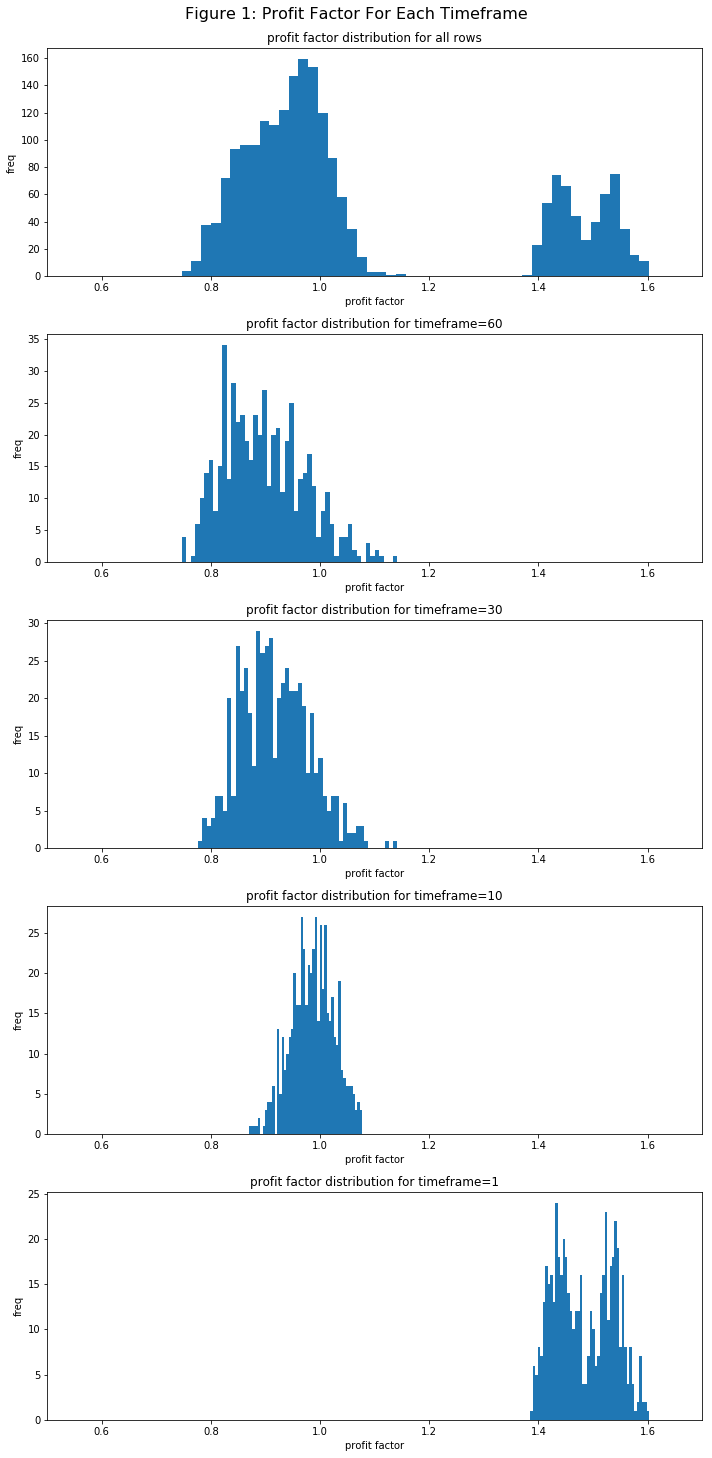

In [6]:
profit_factor_analysis(normal_results, "Figure 1: Profit Factor For Each Timeframe")

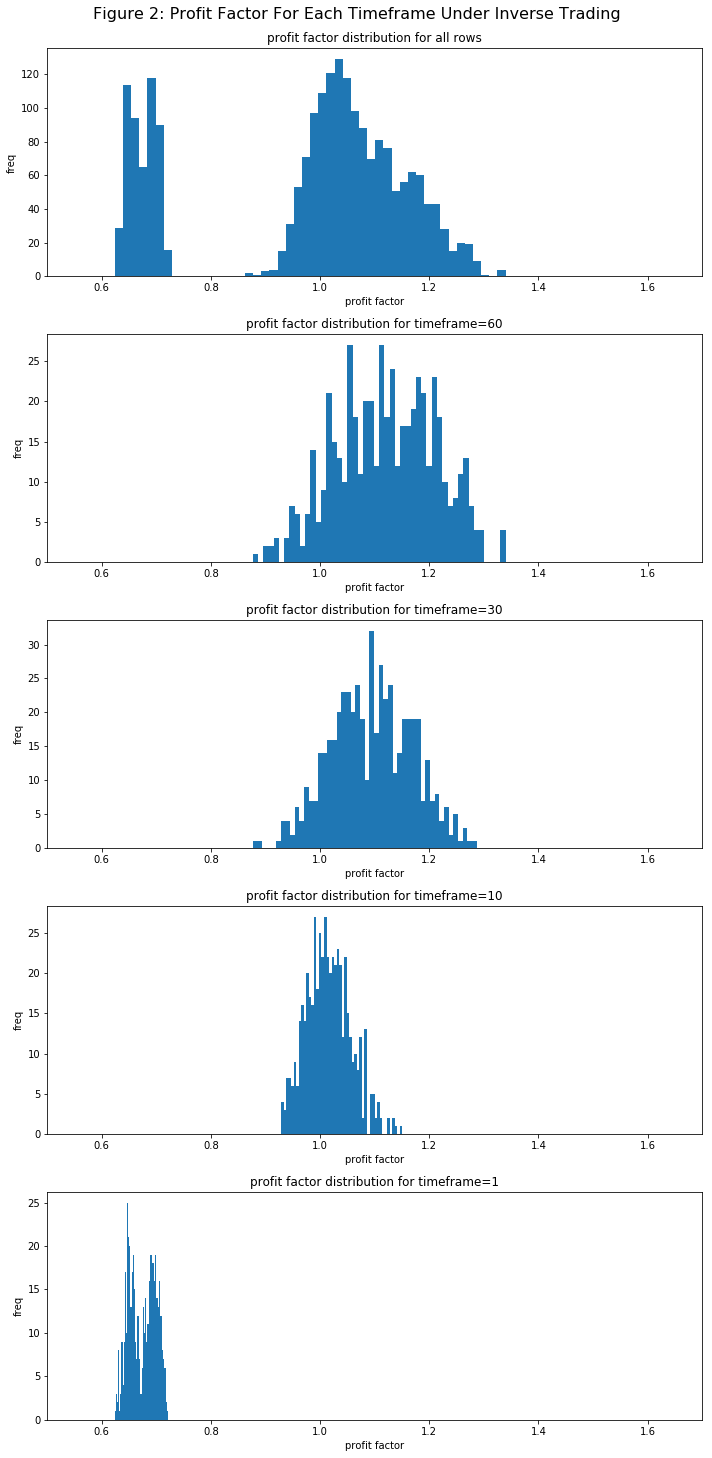

In [7]:
profit_factor_analysis(inversed_results, "Figure 2: Profit Factor For Each Timeframe Under Inverse Trading")

# Profit factor histogram summary
## distribution

As you see, Figure 1 hisograms show tendency that the shorter timeframe, the better profit factor.
However, it may be implied that the result caused by just a overfitting and such parameters with short timeframe
would work not well in real environment.

In this part, record the average rank for each timeframe and parameter.
The calculation order is bottom -> middle -> top, because the shorter tick has larger effect to the result.
Hence the result of calculation regard as a representative and optimal parameter for each timeframe.

After that, simulate the investment result 100,000 times using bootstrap method with these representative parameters,
then check the investment simulation result of average, mode, median and percentile.

Figure1の最初のグラフを見ると、きれいな双峰分布になっていることが見て取れる。
続いてtimeframe別のグラフを見ていくと、timeframeが小さくなっていくにつれてプロフィットファクターが大きくなっていることがわかる。
だがこの傾向があまりに明白であることと、timeframe、すなわち時間足が短くなればなるほど良い結果が得られることから、
これらのパラメータが過剰にデータセットに適合していて、本番環境ではうまくいかない可能性がある。

Figure2の最初のグラフを見ると、Figure1とプロフィットファクターが1の箇所で線対称なグラフになっている。
続いてFigure2の2つ目のグラフを見ていくと、timeframeが60の時に最も期待プロフィットファクターが高くなっている。

そこで各timeframeごとに、それぞれのパラメーターに対して平均的な順位を記録する。
結果への影響力は、短期的な価格変動の効果を受けにくい順に大きいため、bottom -> middle -> topの順で平均的な順位を計算する。
その中で得られた最適なパラメータを各タイムフレームの代表的なパラメーターとする。

In [8]:
def find_best_ranking_parameter(sorted_df_in_need_with_timeframe, tick_params, bottom_trend_tick=None, middle_trend_tick=None, verbose=False):
    optimal_tick = 0
    max_tick_ranking = 0
    
    # tick optimize detection
    if bottom_trend_tick is None and middle_trend_tick is None:
        base_query = "bottom_trend_tick == "        
                
    elif bottom_trend_tick is not None and middle_trend_tick is None:
        base_query = "bottom_trend_tick == " + str(bottom_trend_tick) + " and middle_trend_tick == "
            
    elif bottom_trend_tick is not None and middle_trend_tick is not None:
        base_query = "bottom_trend_tick == " + str(bottom_trend_tick) + " and middle_trend_tick ==" +\
                    str(middle_trend_tick) + " and top_trend_tick == "
        
    return get_max_ranking_tick(sorted_df_in_need_with_timeframe, base_query, tick_params, verbose=verbose)

def get_max_ranking_tick(sorted_df_in_need_with_timeframe, base_query, tick_params, verbose=False):
    max_tick_ranking = 0
    optimal_tick = 0
    
    for tick in tick_params:
        df = sorted_df_in_need_with_timeframe.query(base_query + str(tick))
                    
        denominator = len(df)
        numerator = df.index.values.sum()
            
        average_ranking = numerator/denominator
        if verbose is True:
            print("denominator => " + str(denominator) + " numerator => " + str(numerator) + " tick => " + str(tick) +\
              " average ranking => " + str(average_ranking))
            
        if average_ranking < max_tick_ranking or max_tick_ranking == 0:
            max_tick_ranking = average_ranking
            optimal_tick = tick
            
    return optimal_tick
    

def find_optimal_parameters_by_ranking(df, verbose=False):
    sorted_df_in_need = df[[
        "timeframe",
        "bottom_trend_tick",
        "middle_trend_tick",
        "top_trend_tick",
        "profit_factor"]
    ].sort_values("profit_factor", ascending=False)
    
    timeframe_params = [60,30,10,1]
    bottom_trend_tick_params = [5,10,15,20,25,30,35,40,45,50]
    middle_trend_tick_params = [3,5,7,9,12,15,18,21,24,27,30]
    top_trend_tick_params = [1,2,3,4,5,6,7,8]
    
    for timeframe in timeframe_params:
        print("calc optimal parameters for timeframe:" + str(timeframe))
        sorted_df_in_need_with_timeframe = sorted_df_in_need.query("timeframe ==" + str(timeframe))
        if verbose:
            print("bottom")
        optimal_bottom = find_best_ranking_parameter(sorted_df_in_need_with_timeframe,
            bottom_trend_tick_params, verbose=verbose)
        if verbose:
            print("middle with bottom => " + str(optimal_bottom) )
        optimal_middle = find_best_ranking_parameter(sorted_df_in_need_with_timeframe,
            middle_trend_tick_params, bottom_trend_tick=optimal_bottom, verbose=verbose)
        if verbose:
            print("top with bottom => " + str(optimal_bottom) + " middle => " + str(optimal_middle))
        optimal_top = find_best_ranking_parameter(sorted_df_in_need_with_timeframe,
            top_trend_tick_params, bottom_trend_tick=optimal_bottom, middle_trend_tick=optimal_middle, verbose=verbose)
        
        print("optimal bottom => " + str(optimal_bottom) + " middle => " + str(optimal_middle) + "top => " + str(optimal_top))            

In [9]:
print("normal results")
find_optimal_parameters_by_ranking(normal_results, verbose=False)

print("\nnormal results 20% percentile")
find_optimal_parameters_by_ranking(normal_results.query(
    str(normal_results.quantile(0.75).profit_factor) + " < profit_factor"))


normal results
calc optimal parameters for timeframe:60
optimal bottom => 5 middle => 3top => 2
calc optimal parameters for timeframe:30
optimal bottom => 5 middle => 3top => 1
calc optimal parameters for timeframe:10
optimal bottom => 5 middle => 3top => 1
calc optimal parameters for timeframe:1
optimal bottom => 5 middle => 3top => 1

normal results 20% percentile
calc optimal parameters for timeframe:60
optimal bottom => 5 middle => 3top => 1
calc optimal parameters for timeframe:30
optimal bottom => 5 middle => 3top => 1
calc optimal parameters for timeframe:10
optimal bottom => 5 middle => 3top => 1
calc optimal parameters for timeframe:1
optimal bottom => 5 middle => 3top => 1


      backtest_summary_id  timeframe  profit_factor  bottom_trend_tick  \
1578                 1579          1        1.53492                  5   
1592                 1593          1        1.50108                 10   
1586                 1587          1        1.51321                 10   
1582                 1583          1        1.50497                 10   
1580                 1581          1        1.54636                 10   
1664                 1665          1        1.48866                 20   
1600                 1601          1        1.52652                 15   
1579                 1580          1        1.56859                  5   
1593                 1594          1        1.55338                 10   
1581                 1582          1        1.58942                 10   
1587                 1588          1        1.56360                 10   
1583                 1584          1        1.57451                 10   
1621                 1622          1  

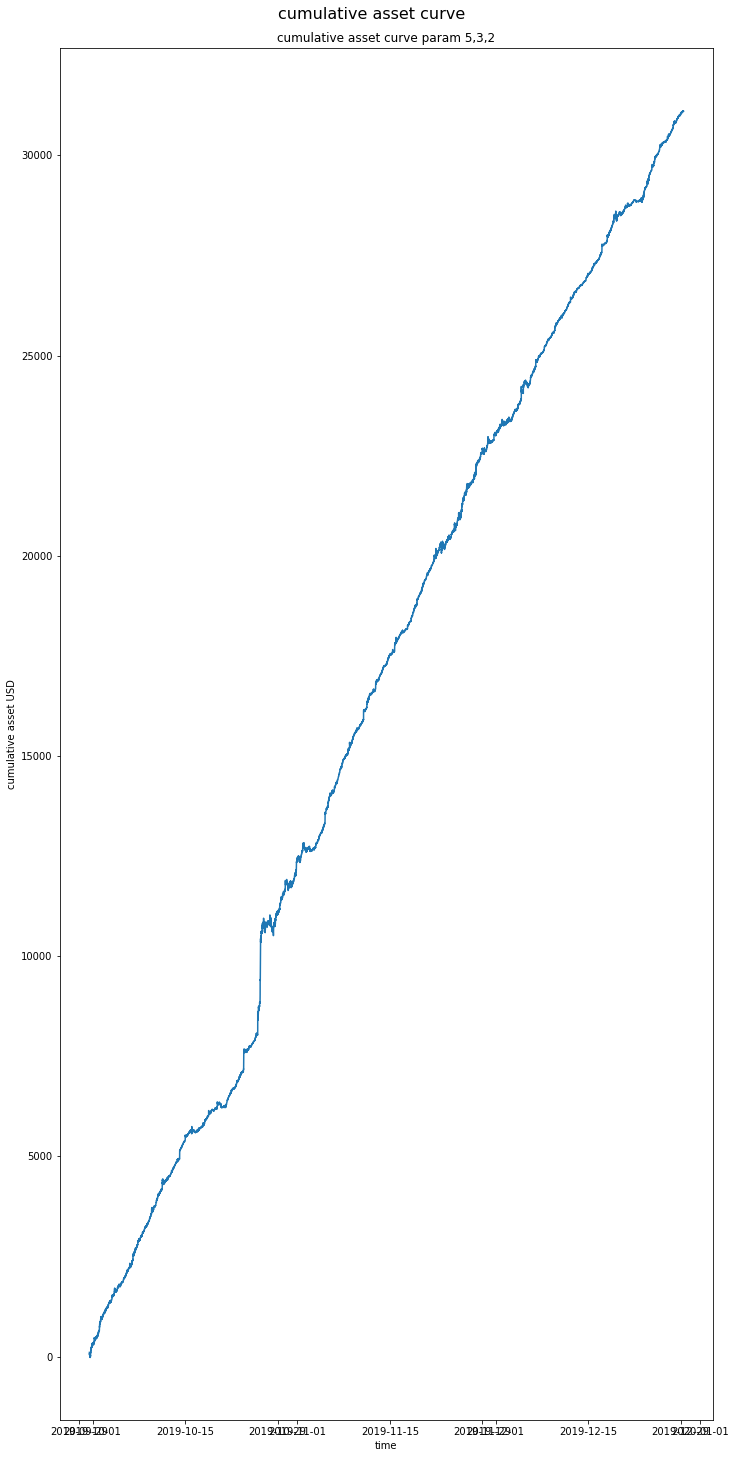

In [10]:
normal_sorted_df_in_need = normal_results.sort_values("profit_factor", ascending=False)

top_5_percentile = normal_results.query(str(normal_results.quantile(0.99).total_return) + " < total_return")[[
    "backtest_summary_id", "timeframe", "profit_factor", "bottom_trend_tick", "middle_trend_tick", "top_trend_tick", "total_entry",
    "win_rate", "total_return"]]

print(top_5_percentile.sort_values("total_entry", ascending=False))
top_5_percentile_list = list(top_5_percentile.sort_values("total_return", ascending=False).index.values)
print(top_5_percentile_list)

from model.backtest_summary import BacktestSummary

q = rk.mysql_client.session.query(BacktestSummary).filter(BacktestSummary.id==1581).all()[0]
a = rk.mysql_client.model_to_dataframe(q.backtest_transaction_log)

asset_figure = rk.plt.figure()
asset_figure.suptitle("cumulative asset curve", fontsize=16, y=1.01)
graph = asset_figure.add_subplot(1,1,1)
graph.set_title("cumulative asset curve param 5,3,2")
graph.set_xlabel("time")
graph.set_ylabel("cumulative asset USD")
asset_figure.tight_layout()
rk.plt.rcParams['figure.figsize'] = (10.0, 10.0)
graph.plot(a.close_time, a.current_balance)


In [11]:
def draw_asset_curve(dataframe, percentile, reverse_ranking=False, title="cumulative asset curves"):
    if reverse_ranking:
        reversed_df = dataframe.sort_values("profit_factor", ascending=True)
        top_n_percentile = reversed_df.query(str(reversed_df.quantile(percentile).profit_factor) + " > profit_factor")
    else:        
        top_n_percentile = dataframe.query(str(dataframe.quantile(percentile).profit_factor) + " < profit_factor")
    figure_width = 1
    figure_height = len(top_n_percentile)/figure_width + 1
    
    figure_nums = len(top_n_percentile)
    
    asset_figure = rk.plt.figure()
    asset_figure.suptitle("cumulative asset curve", fontsize=16, y=1.01)
    asset_figure.subplots_adjust(wspace=0.4, hspace=0.6)
    
    for i, row in enumerate(top_n_percentile.itertuples()):
        summary_model_obj = rk.mysql_client.session.query(BacktestSummary).filter(BacktestSummary.id==row.backtest_summary_id).all()[0]
        transaction_log_df = rk.mysql_client.model_to_dataframe(summary_model_obj.backtest_transaction_log)
        graph = asset_figure.add_subplot(figure_height,figure_width,i+1)
        graph.set_title("cumulative asset curve id:" + str(row.Index) + " (bottom:" + str(row.bottom_trend_tick) + ", middle:" +\
                       str(row.middle_trend_tick) + ", top:" + str(row.top_trend_tick) + ", timeframe:" +\
                       str(row.timeframe))
        graph.set_xlabel("time")
        graph.set_ylabel("asset USD")
        graph.plot(a.close_time, a.current_balance)
        
    asset_figure.tight_layout()
    rk.plt.rcParams['figure.figsize'] = (13.0, 13.0)
        
#draw_asset_curve(normal_results, 0.99)
#draw_asset_curve(inversed_results, 0.99)
    

backtest_summary_id             1579
timeframe                          1
close_position_on_do_nothing       1
inverse_trading                    0
bottom_trend_tick                  5
middle_trend_tick                  3
top_trend_tick                     1
Name: 1579, dtype: int64
absolute_drawdown                                       55.5723
account_currency                                            USD
backtest_end_time                           2019-12-29 11:00:00
backtest_start_time                         2019-09-30 12:00:00
bot_name                                    bottom_trend_follow
id                                                         1579
initial_balance                                             100
long_average_holding_ms                         0 days 00:01:48
long_entry                                                16040
long_kurtosis                                           907.589
long_kurtosis_percentage                                2095.35
long_max_los

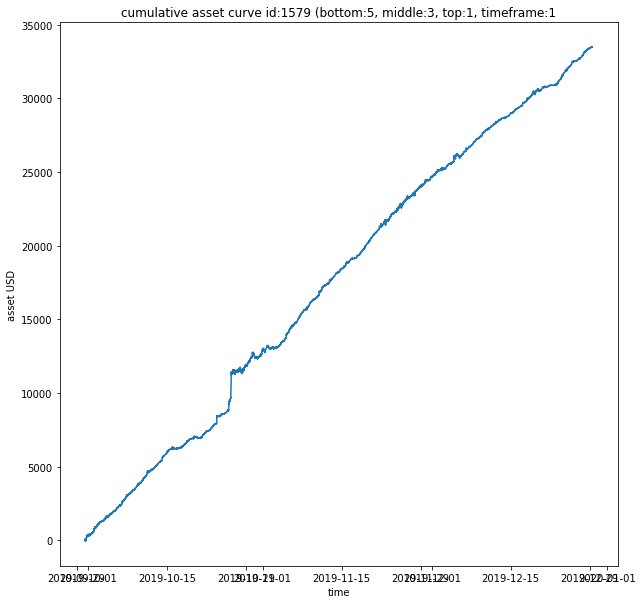

In [12]:
def generate_summary_by_id(summary_id):
    from model.backtest_summary import BacktestSummary
    from model.backtest_management import BacktestManagement
    
    summary_model_obj = rk.mysql_client.session.query(BacktestSummary).filter(BacktestSummary.id==summary_id).all()[0]
    
    summary_df = rk.mysql_client.model_to_dataframe([summary_model_obj]).iloc[0,:]
    
    params_df = rk.mysql_client.get_row_by_backtest_summary_id("bottom_trend_follow_backtest_management", summary_id).iloc[0,:]
    
    transaction_log_df = rk.mysql_client.model_to_dataframe(summary_model_obj.backtest_transaction_log)
    print(params_df)
    print(summary_df)
    
    
    asset_figure = rk.plt.figure()
    graph = asset_figure.add_subplot(111)
    graph.set_title("cumulative asset curve id:" + str(summary_id) + " (bottom:" + str(params_df.bottom_trend_tick) + ", middle:" +\
        str(params_df.middle_trend_tick) + ", top:" + str(params_df.top_trend_tick) + ", timeframe:" +\
        str(params_df.timeframe))
    graph.set_xlabel("time")
    graph.set_ylabel("asset USD")
    graph.plot(transaction_log_df.close_time, transaction_log_df.current_balance)
    

best_summary_id = 1579
generate_summary_by_id(best_summary_id)

## Findings from searching optimal parameters

当初これはトレンドフォロー型のbotで、長期で大きく勝つことで高い収益をもたらすという先入観があった。
しかし結果を見るとこのbotは1分足で、しかも短期で頻繁に売買することで利益を上げるスキャルピングに強いことがわかった。
またパラメータも、小さければ小さいほど良いことが傾向として示された。

最終的には1分足でbottom tickは5, middle tickは3, top tickは1の場合が最適であるという結論を得た。

そこで次はどのような時に負けるか、どのような時に勝つのかを分析して、このbotの収益性を高める戦略の緒を探す。
そのためにはマーケットの指標としてテクニカル指標を導入する。

具体的には、このテストで使ったOHLCVデータに対してテクニカル指標を追加し、それを取引ログに結合することで、勝ちトレードと負けトレードがどのような時に発生しているのかという傾向を探る。MACDについては、価格そのものに意味は薄いのでその変化率をみる。

また、勝ちおよび負けトレードが予測可能かどうかも探る。これは最初の80日をtrainに、そして残りの10日をtestに分割し、その予測精度としてRMSEの大きさを計測する。

この問題は2値分類問題であり、これが可能であるならば勝てそうなトレードに多く賭ける、負けそうなトレードには小さく賭けるor何も賭けないという普遍的な改善策を取ることができる。

ここでは一旦ロジスティック回帰と、後にRNNを試すことにする。

In [13]:
# datasets used in backtest
backtest_start_time = rk.datetime(2019,9,30,11,49)
backtest_end_time = rk.datetime(2019,12,29,11,49)
    
ohlcv_df_1min = rk.dataset_manager.get_ohlcv(start_time=backtest_start_time, end_time=backtest_end_time)

print(len(ohlcv_df_1min))

Loading OHLCV data from bitmex_original_ohlcv_1min now...
Done
129541


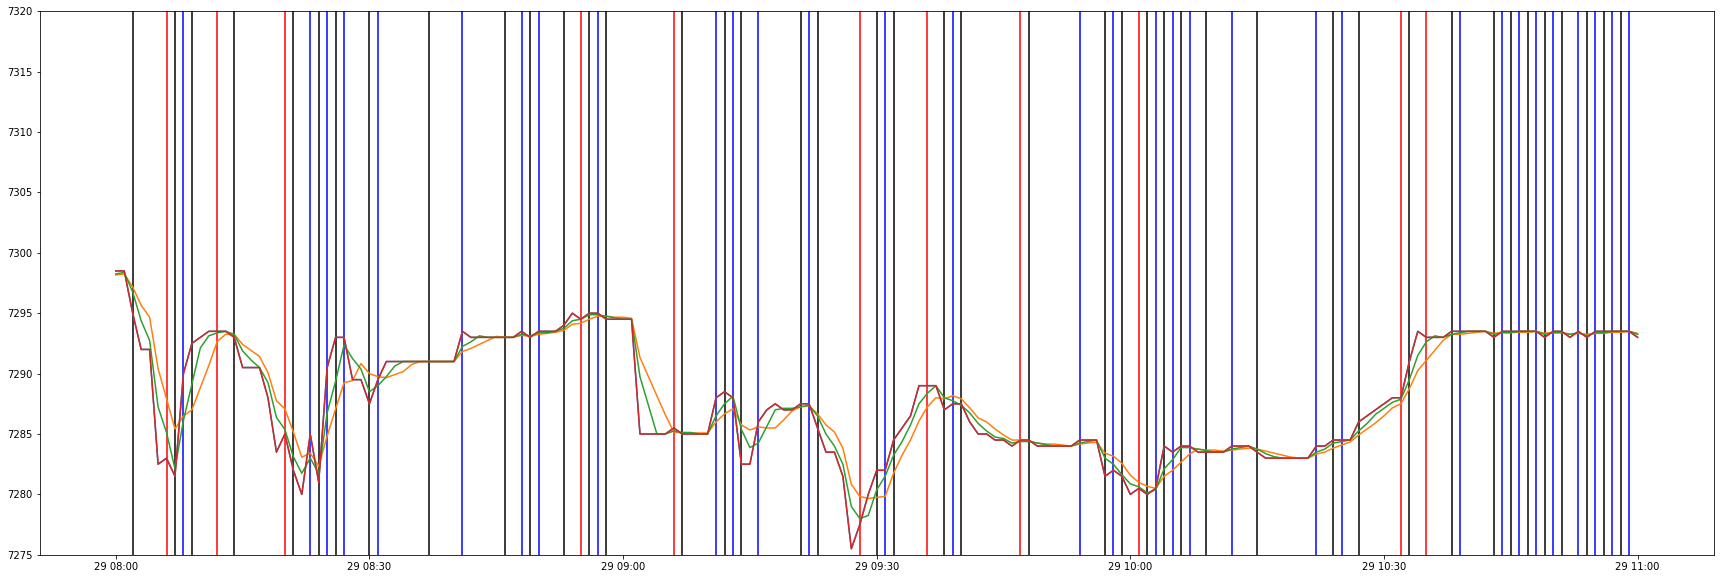

In [29]:
from model.backtest_summary import BacktestSummary
def add_technical_statistics_to_ohlcv_df(df):
    from technical_analysis.ad import TechnicalAnalysisAD
    from technical_analysis.atr import TechnicalAnalysisATR
    from technical_analysis.bollinger_band import TechnicalAnalysisBB
    from technical_analysis.MACD import TechnicalAnalysisMACD
    from technical_analysis.SAR import TechnicalAnalysisSAR
    
    ta_ad = TechnicalAnalysisAD(df)
    ad_df = ta_ad.get_ad()

    ta_atr = TechnicalAnalysisATR(df)
    atr_df = ta_atr.get_atr()

    ta_sar = TechnicalAnalysisSAR(df)
    sar_df = ta_sar.get_psar_trend()

    ta_macd = TechnicalAnalysisMACD(df)
    macd_tick = [5,3,1]
    # already append these 3 cols
    ema_5 = ta_macd.append_ema_close(5)
    ema_3 = ta_macd.append_ema_close(3)
    ema_1 = ta_macd.append_ema_close(1)

    ta_applied = rk.pd.concat([df, ad_df, atr_df], axis=1)
    ta_applied.dropna(inplace=True)

    return ta_applied

ohlcv_with_ta = add_technical_statistics_to_ohlcv_df(ohlcv_df_1min)

pickup_time = rk.datetime(2019,12,29,8)
end_time = rk.datetime(2019,12,30)

picked_df = ohlcv_with_ta[pickup_time:end_time]

def get_transaction_logs_by_summary_id(summary_id):
    summary_model_obj = rk.mysql_client.session.query(BacktestSummary).filter(BacktestSummary.id==summary_id).all()[0]
    transaction_log_df = rk.mysql_client.model_to_dataframe(summary_model_obj.backtest_transaction_log)
    return transaction_log_df

transaction_log_df = get_transaction_logs_by_summary_id(best_summary_id) # 1579

picked_transaction_log_df = transaction_log_df[transaction_log_df.entry_time > pickup_time]
win_picked = picked_transaction_log_df[transaction_log_df.profit_status == "win"]
lose_picked = picked_transaction_log_df[transaction_log_df.profit_status == "lose"]

entry_times = list(picked_transaction_log_df.entry_time)

win_close_times = list(win_picked.close_time)
lose_close_times = list(lose_picked.close_time)

rk.plt.rcParams['figure.figsize'] = (30.0, 10.0)
rk.plt.plot(picked_df.index, picked_df.close)
rk.plt.plot(picked_df.index, picked_df.ema_5)
rk.plt.plot(picked_df.index, picked_df.ema_3)
rk.plt.plot(picked_df.index, picked_df.ema_1)
rk.plt.ylim(7275, 7320)
rk.plt.vlines(entry_times, ymin=7000, ymax=8000, color="black")
rk.plt.vlines(win_close_times, ymin=7000, ymax=8000, color="red")
rk.plt.vlines(lose_close_times, ymin=7000, ymax=8000, color="blue")

黒のラインがエントリーポイント。赤のラインが勝利、青のラインが敗北。
最後の取引を見るとレンジ相場に弱そうである。
ところどころトレンド相場で負けているのも気になるところ。
勝ちトレードの平均取引時間が長いことも見て取れる。
また低い勝率ながら大き目の勝ちを重ねていることもわかる。

レンジ相場に入る直前の勝率が高そうな感じがする。
勝っているトレンド相場と負けているトレンド相場の違いも気になる。

['asset_name_x', 'backtest_summary_id', 'close_price', 'close_time', 'current_balance', 'entry_price', 'entry_time', 'exchange_name_x', 'id_x', 'leverage', 'lot', 'order_status', 'order_type', 'price_difference', 'price_difference_percentage', 'profit_percentage', 'profit_size', 'profit_status', 'transaction_cost', 'asset_name_y', 'close', 'exchange_name_y', 'high', 'id_y', 'low', 'open', 'volume', 'psar', 'psar_trend', 'ema_5', 'ema_3', 'ema_1', 'ad', 'atr']


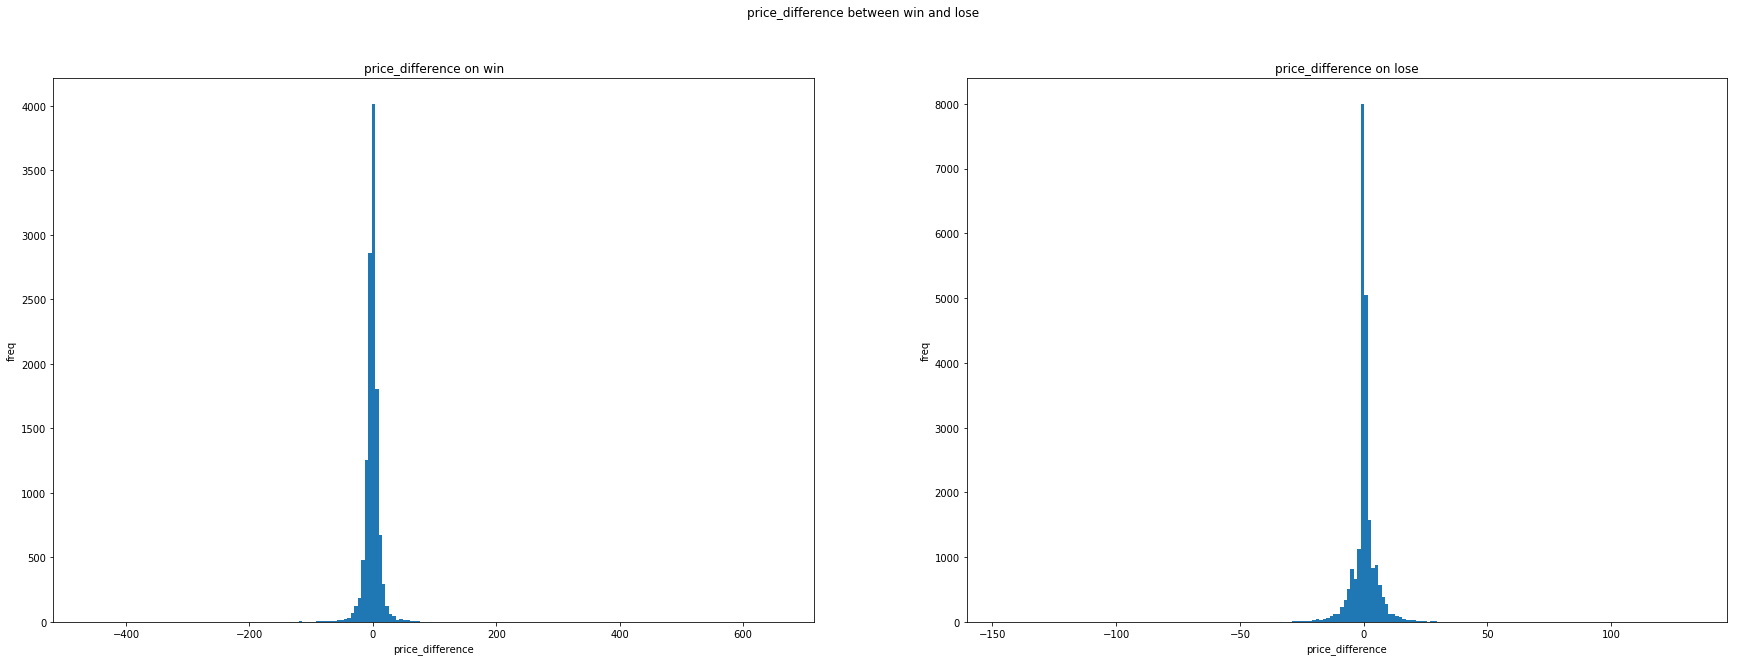

win price_difference mean => -0.6610335537594906
lose price_difference mean => 0.3496533025157792
win price_difference standard deviation => 16.805698679575492
lose price_difference standard deviation => 5.544292039038671
win price_difference median => -0.5
lose price_difference median => 0.0


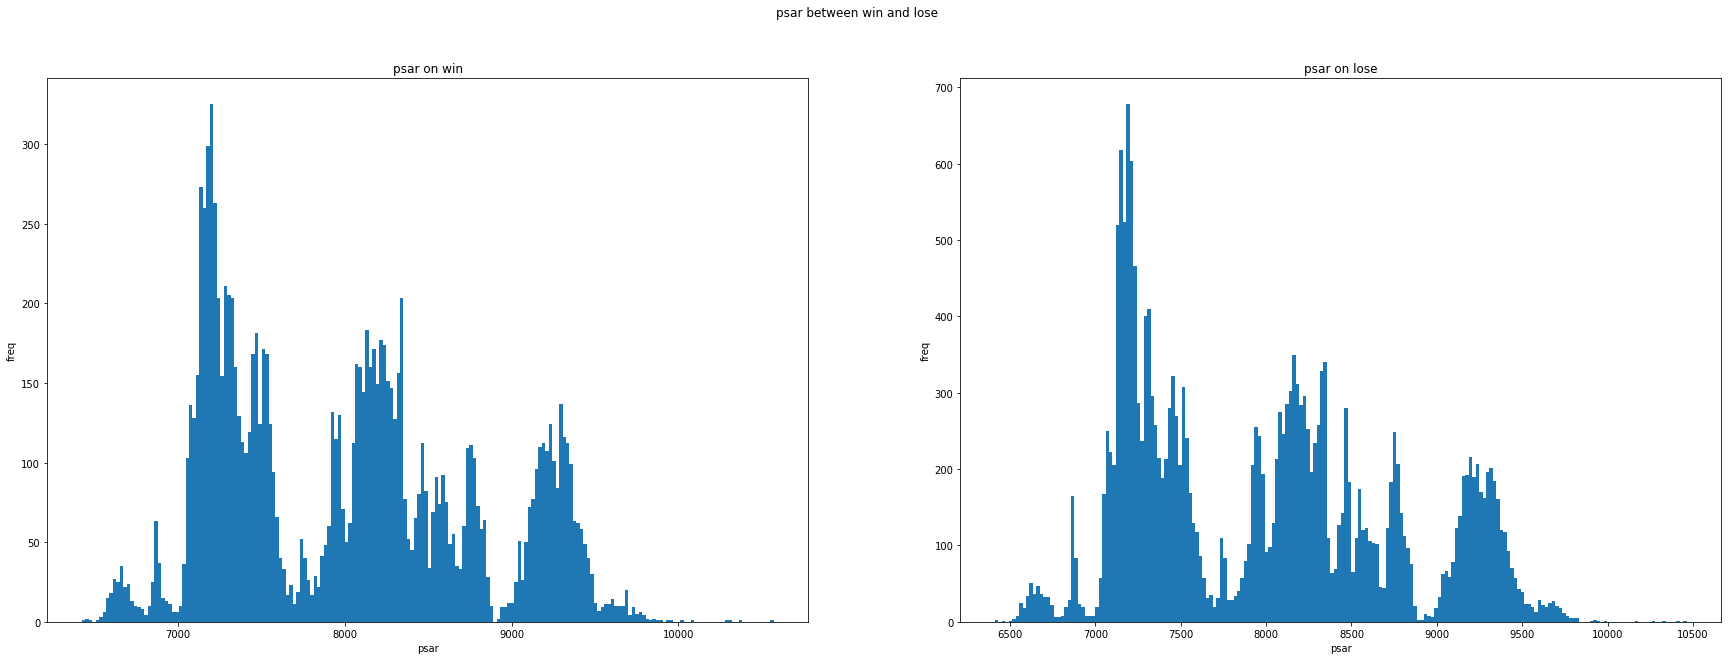

win psar mean => 8012.793134019994
lose psar mean => 7992.145522968202
win psar standard deviation => 769.2251508117964
lose psar standard deviation => 767.5666418760221
win psar median => 8036.674836888934
lose psar median => 7982.396572239615


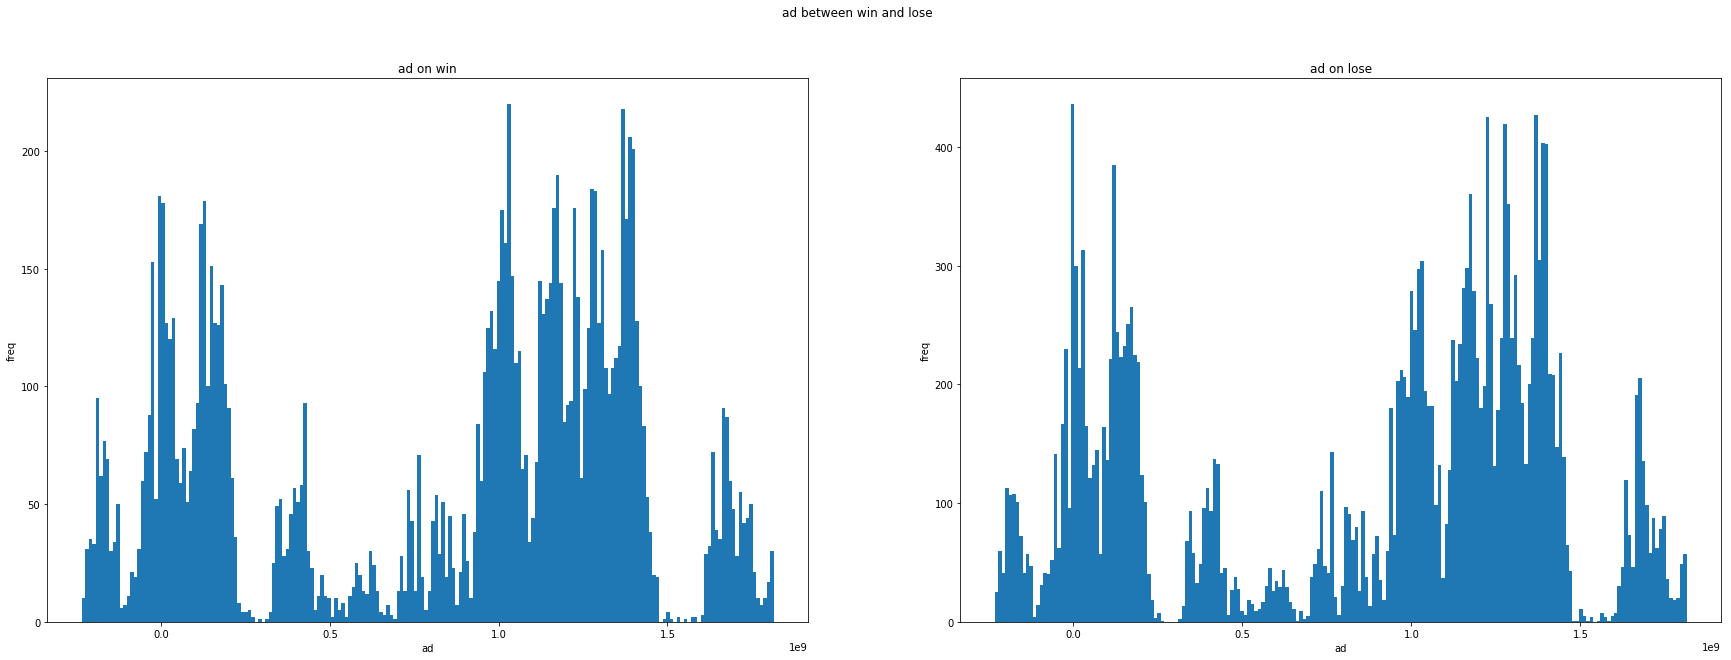

win ad mean => 822385687.0832797
lose ad mean => 844113631.4416916
win ad standard deviation => 573732388.5353075
lose ad standard deviation => 572433674.6161107
win ad median => 1022265175.1040338
lose ad median => 1033494826.7487068


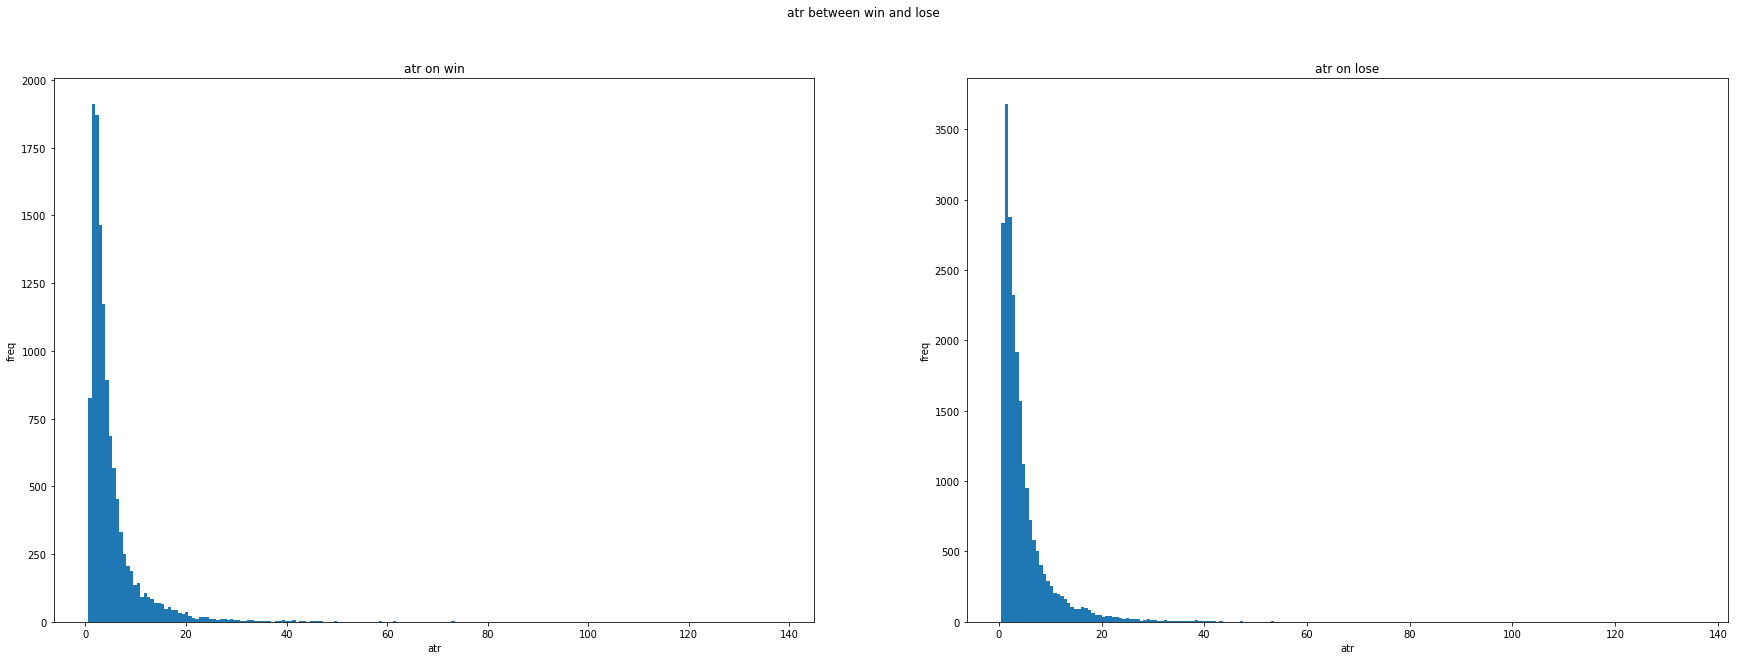

win atr mean => 5.157027895013926
lose atr mean => 4.746358796517416
win atr standard deviation => 6.40613784173459
lose atr standard deviation => 5.630535794574721
win atr median => 3.3216729828604703
lose atr median => 3.0333029542829806


In [32]:
win_transaction_log = transaction_log_df[transaction_log_df.profit_status == "win"]
lose_transaction_log = transaction_log_df[transaction_log_df.profit_status == "lose"]

win_merged = rk.pd.merge(win_transaction_log, ohlcv_with_ta, left_on="close_time", right_on=ohlcv_with_ta.index)
lose_merged = rk.pd.merge(lose_transaction_log, ohlcv_with_ta, left_on="close_time", right_on=ohlcv_with_ta.index)
   
def create_hist(win_data, lose_data, focus_factor=""):
    win = win_merged[focus_factor]
    lose = lose_merged[focus_factor]
    
    bins = 200
    
    figure = rk.plt.figure()
    figure.suptitle(focus_factor + " between win and lose")
    
    for i, win_lose in enumerate(["win", "lose"]):
        graph = figure.add_subplot(1,2,1+i)
        if win_lose == "win":
            graph.hist(win, bins=bins)
        else:
            graph.hist(lose, bins=bins)
        graph.set_title( focus_factor + " on " + win_lose)
        graph.set_xlabel(focus_factor)
        graph.set_ylabel("freq")
        
    rk.plt.show()
        
    win_mean = win_merged[focus_factor].mean()
    lose_mean = lose_merged[focus_factor].mean()
    print("win " + focus_factor + " mean => " + str(win_mean))
    print("lose " + focus_factor + " mean => " + str(lose_mean))
    
    win_std = win_merged[focus_factor].std()
    lose_std = lose_merged[focus_factor].std()
    print("win " + focus_factor + " standard deviation => " + str(win_std))
    print("lose " + focus_factor + " standard deviation => " + str(lose_std))
    
    win_med = win_merged[focus_factor].median()
    lose_med = lose_merged[focus_factor].median()
    print("win " + focus_factor + " median => " + str(win_med))
    print("lose " + focus_factor + " median => " + str(lose_med))
    

    
def win_lose_stat(win_merged, lose_merged):
    # price difference
    create_hist(win_merged, lose_merged, "price_difference")
    create_hist(win_merged, lose_merged, "psar")
    create_hist(win_merged, lose_merged, "ad")
    create_hist(win_merged, lose_merged, "atr")
    
print(list(win_merged.columns))
    
win_lose_stat(win_merged, lose_merged)



In [30]:
win_long = win_merged[win_merged.order_type == "long"]
win_short = win_merged[win_merged.order_type == "short"]

win_long_cond = len(win_long) / len(win_merged)
win_short_cond = len(win_short) / len(win_merged)

print("long propotion on win => " + str(win_long_cond))
print("short propotion on win => " + str(win_short_cond))

lose_long = lose_merged[lose_merged.order_type == "long"]
lose_short = lose_merged[lose_merged.order_type == "short"]

lose_long_cond = len(lose_long) / len(lose_merged)
lose_short_cond = len(lose_short) / len(lose_merged)

print("\n")
print("long propotion on lose => " + str(lose_long_cond))
print("short propotion on lose => " + str(lose_short_cond))

long propotion on win => 0.47187525512286715
short propotion on win => 0.5281247448771328


long propotion on lose => 0.45599608854120366
short propotion on lose => 0.5440039114587963


見たところこれらの指標において勝ちトレードと負けトレードの差はあまりなさそうである。

### price difference
勝ちの値幅の変動がマイナスであること、負けの値幅の変動がマイナスである。
勝ちの値幅の標準偏差が負けに比べて非常に大きい。

勝っているときの値幅の変動がマイナスであることから、勝ちトレードにショートが多いと予想した。
結果は予想通りだったが、負けトレードにおけるショートの割合はさらに多かった。
ここにおいてはハイリスクハイリターンの関係が成立している。

### psar
標準偏差はどちらの場合も大きく、平均も大きな差があるようには見えない。

グラフからは大きく3つの山が存在していることが確認できる。
左から順々に小さくなっていることがわかる。
この3つの山は3種類の状態が存在することを意味しているのかもしれない。

[MT5のページ](https://www.metatrader5.com/ja/terminal/help/indicators/trend_indicators/psar)によるとpsarにはトレンド相場がブルであるかベアであるかを検出することができるそうだ。
そこから考えると、トレンド相場のうちのブル相場、ベア相場、レンジ相場がこの3つの山に対応していそうである。
しかしそれ以外の可能性として、3ヶ月の値動きの、それぞれの月の平均的な位置がこの3つの山の中心にあることが挙げられる。
また、もしその3つの相転移が存在するならば、負けトレードにもブル、ベア、レンジの3つの山ができるのは、ブル、ベアのトレンド相場に強いbotの特性からすると妙である。

PSARはジャンプを特徴としている。この値がジャンプした際にはトレンドの転換、すなわち相転移の発生を検出する。

uptrend、すなわちbullかとdowntrend、すなわちbearかはpsar_trendの値を見るとわかる。
ここでの問題はuptrendとdowntrendが2つの値しか取らないことである。
つまり原理的にPSARの返り値にはレンジ相場が存在しない。

ただPSARの返り値はbottom trend followのbotに対して相性が良さそうだ。
より具体的には取引回数、頻度をそこまで下げることなく勝率を向上させることができそうだ。

### ad
標準偏差はどちらの場合も大きく、平均も大きな差があるようには見えない。

[このページ](https://xn--hck6a9a3a3cl0j7al2328j687d.com/?p=4932)がADラインの説明としてわかりやすい。
この指標はダイバージェンスを検出する指標として使われる。もっぱら逆張りの用途で使われるようだが、逆に言えばこのダイバージェンスが起きていないときはトレンド相場が続くと判断することが可能になる。

またbitcoinの価格の変動が大きいということはつまり安定していないということであり、安定していないならば値が上がるか下がるかのみである。
このグラフにはうっすらと2つの山が見えているが、これは値が上がるか下がるか、つまりブル相場かベア相場かの2種類の状態を表していると
推測することができる。

### ATR
標準偏差はどちらの場合も大きく、平均も大きな差があるようには見えない。

だがこの指標の特徴として高値-安値なので0以上の値のみしかとらないという点がある。
[ATRの説明はこちら](http://www.avatrade.co.jp/kojiro/13/)が詳しい。
ATRが増大している時はトレンド相場、ATRが縮小しているときはレンジ相場である。

それを鑑みると、勝ちトレードのATRが負けトレードのATRに比べて大きい傾向があることから、トレンドフォロー型botの特性を備えていると言える可能性がある。